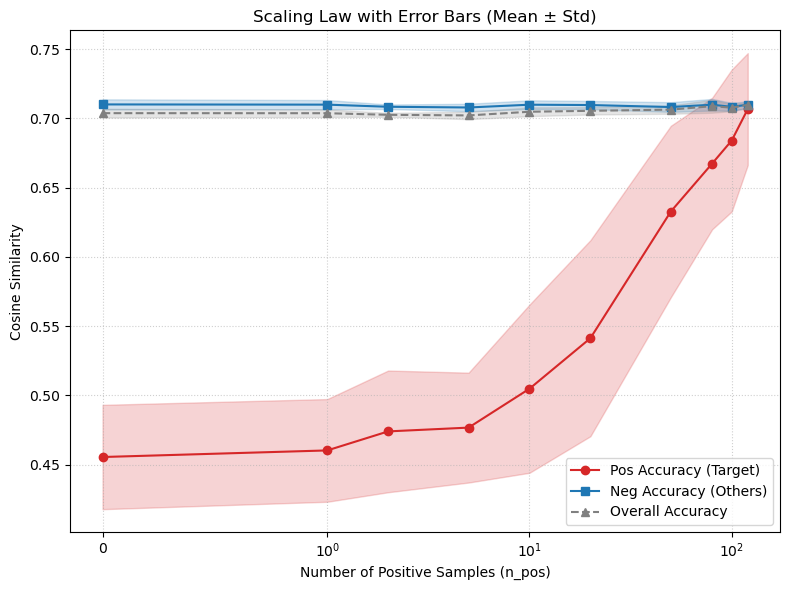

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. データの読み込み
df = pd.read_csv("output/csv/result_5000mols_f.csv") 
# ※ここでは提示されたデータ形式と同じ構造を持つDataFrameがあると仮定します

# 2. 集計 (seedごとの平均と標準偏差を算出)
grouped = df.groupby("n_pos_req").agg({
    "pos_acc": ["mean", "std"],
    "neg_acc": ["mean", "std"],
    "overall_acc": ["mean", "std"]
}).reset_index()

# カラム名の整理 (pos_acc_mean, pos_acc_std ... という名前にする)
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]

# 3. プロット
plt.figure(figsize=(8, 6))

x = grouped["n_pos_req"]

# --- Pos Accuracy (赤色) ---
mean = grouped["pos_acc_mean"]
std = grouped["pos_acc_std"]
plt.plot(x, mean, marker='o', color='tab:red', label='Pos Accuracy (Target)')
# ★ここで fill_between を使用
plt.fill_between(x, mean - std, mean + std, color='tab:red', alpha=0.2)

# --- Neg Accuracy (青色) ---
mean = grouped["neg_acc_mean"]
std = grouped["neg_acc_std"]
plt.plot(x, mean, marker='s', color='tab:blue', label='Neg Accuracy (Others)')
plt.fill_between(x, mean - std, mean + std, color='tab:blue', alpha=0.2)

# --- Overall Accuracy (灰色) ---
mean = grouped["overall_acc_mean"]
std = grouped["overall_acc_std"]
plt.plot(x, mean, marker='^', linestyle='--', color='gray', label='Overall Accuracy')
plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2)

# 装飾
plt.xlabel('Number of Positive Samples (n_pos)')
plt.ylabel('Cosine Similarity')
plt.title('Scaling Law with Error Bars (Mean ± Std)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xscale('symlog', linthresh=1)
plt.legend()

plt.tight_layout()
plt.savefig("output/figure/result_5000mols_f.png", dpi=300)
plt.show()